In [1]:
%matplotlib widget
from matplotlib import pyplot as plt
import numpy as np
def plotscatter(X_transformed):
    if X_transformed.shape[1]==3:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(X_transformed[:num_fu,0],X_transformed[:num_fu,1],X_transformed[:num_fu,2],c="r",label="fu")
        ax.scatter(X_transformed[num_fu:num_fu+num_notfu,0],X_transformed[num_fu:num_fu+num_notfu,1],X_transformed[num_fu:num_fu+num_notfu,2],c="g",label="notfu")
        ax.scatter(X_transformed[num_fu+num_notfu:num_fu+num_notfu+5,0],X_transformed[num_fu+num_notfu:num_fu+num_notfu+5,1],X_transformed[num_fu+num_notfu:num_fu+num_notfu+5,2],c="b",label="testfu")
        ax.scatter(X_transformed[-5:,0],X_transformed[-5:,1],X_transformed[-5:,2],c="y",label="testnotfu")
        ax.legend()
        ax.grid(True)

        plt.show()
    elif X_transformed.shape[1]==2:
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.scatter(X_transformed[:num_fu,0],X_transformed[:num_fu,1],c="r",label="fu")
        ax.scatter(X_transformed[num_fu:num_fu+num_notfu,0],X_transformed[num_fu:num_fu+num_notfu,1],c="g",label="notfu")
        ax.scatter(X_transformed[num_fu+num_notfu:num_fu+num_notfu+5,0],X_transformed[num_fu+num_notfu:num_fu+num_notfu+5,1],c="b",label="testfu")
        ax.scatter(X_transformed[-5:,0],X_transformed[-5:,1],c="y",label="testnotfu")
        ax.legend()
        ax.grid(True)

        plt.show()
    elif X_transformed.shape[1]==1:
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.scatter(X_transformed[:num_fu,0],0*np.ones(num_fu),c="r",label="fu")
        ax.scatter(X_transformed[num_fu:num_fu+num_notfu,0],1*np.ones(num_notfu),c="g",label="notfu")
        ax.scatter(X_transformed[num_fu+num_notfu:num_fu+num_notfu+5,0],2*np.ones(5),c="b",label="testfu")
        ax.scatter(X_transformed[-5:,0],3*np.ones(5),c="y",label="testnotfu")
        ax.legend()
        ax.grid(True)

In [2]:
from skimage import morphology,draw
import numpy as np
import matplotlib.pyplot as plt
import cv2

def readimage(t_name):
    image = cv2.imread(t_name,cv2.IMREAD_GRAYSCALE)
    ret,image=cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    image=255-image

    #实施骨架算法
    skeleton =morphology.skeletonize(image)

    skeleton=255-skeleton
    image=255-image
    skeleton[skeleton!=255]=0
    return image,skeleton

In [3]:
def features0(t_name):
    # img = cv2.imread(t_name,cv2.IMREAD_GRAYSCALE)
    # ret,img=cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    _,img=readimage(t_name)

    sumleft=np.zeros((10))
    for i in range(10):
        for x in range(50):
            for y in range(500):
                if img[x+i*50][y]==0:
                    sumleft[i]+=y

    sumright=np.zeros((10))
    for i in range(10):
        for x in range(50):
            for y in range(500):
                if img[x+i*50][499-y]==0:
                    sumright[i]+=y

    sumup=np.zeros((10))
    for i in range(10):
        for y in range(50):
            for x in range(500):
                if img[x][y+i*50]==0:
                    sumup[i]+=x

    sumdown=np.zeros((10))
    for i in range(10):
        for y in range(50):
            for x in range(500):
                if img[499-x][y+i*50]==0:
                    sumdown[i]+=x

    feature2=np.concatenate((sumleft,sumright,sumup,sumdown),axis=0)
    sumleft3=np.zeros((10))
    for i in range(10):
        for x in range(50):
            flag=0
            begin=0
            for y in range(500):
                if img[x+i*50][y]==0 and flag==0:
                    flag+=1
                if img[x+i*50][y]==255 and flag==1:
                    flag+=1
                    begin=y
                if img[x+i*50][y]==0 and flag==2:
                    flag+=1
                    sumleft3[i]+=y-begin

    sumright3=np.zeros((10))
    for i in range(10):
        for x in range(50):
            flag=0
            begin=0
            for y in range(500):
                if img[x+i*50][499-y]==0  and flag==0:
                    flag+=1
                if img[x+i*50][499-y]==255  and flag==1:
                    flag+=1
                    begin=y
                if img[x+i*50][499-y]==0  and flag==2:
                    flag+=1
                    sumright3[i]+=y-begin

    sumup3=np.zeros((10))
    for i in range(10):
        for y in range(50):
            flag=0
            begin=0
            for x in range(500):
                if img[x][y+i*50]==0 and flag==0:
                    flag+=1
                if img[x][y+i*50]==255 and flag==1:
                    flag+=1
                    begin=x
                if img[x][y+i*50]==0 and flag==2:
                    flag+=1
                    sumup3[i]+=x-begin

    sumdown3=np.zeros((10))
    for i in range(10):
        for y in range(50):
            flag=0
            begin=0
            for x in range(500):
                if img[499-x][y+i*50]==0 and flag==0:
                    flag+=1
                if img[499-x][y+i*50]==255 and flag==1:
                    flag+=1
                    begin=x
                if img[499-x][y+i*50]==0 and flag==2:
                    flag+=1
                    sumdown3[i]+=x-begin

    feature3=np.concatenate((sumleft3,sumright3,sumup3,sumdown3),axis=0)
    feature23=np.concatenate((feature2/25,feature3),axis=0)
    return feature23

In [4]:
import os
import numpy as np
from sklearn.cluster import KMeans
from feature import feature


class BoW:
    def __init__(self, PathofData, dim=50, method="sift", data_dim=128) -> None:
        self.dim = dim
        self.method = method
        self.data_dim = data_dim
        data = np.empty([0, data_dim])
        for i in PathofData:
            if method in ["sift", "surf", "orb"]:
                feat = feature(i, method, show=False)[1]
            elif method == "shi-tomasi":
                feat = np.squeeze(feature(i, method, show=False))
            else:
                print("no method. ")
                return []
            if feat is not None:
                data = np.concatenate((data, feat), axis=0)
        kmeans = KMeans(n_clusters=dim, random_state=0, n_init="auto").fit(data)
        self.kmeans = kmeans

    def fit(self, PathofData):
        N = len(PathofData)
        Word = np.zeros([N, self.dim])
        for index, i in enumerate(PathofData):
            if self.method in ["sift", "surf", "orb"]:
                feat = feature(i, self.method, show=False)[1]
            elif self.method == "shi-tomasi":
                feat = np.squeeze(feature(i, self.method, show=False))
            else:
                print("no method. ")
                return []
            if feat is not None:
                label = self.kmeans.predict(feat.astype(float))
                hist, _ = np.histogram(label, bins=range(self.dim + 1))
            else:
                hist=np.zeros((1,self.dim))
            if np.sum(hist)!=0:
                hist=hist/np.sum(hist)
            Word[index] = hist
        return Word
    
    def getSPM(self, PathofData,level):
        width = 500
        N = len(PathofData)
        Word = np.zeros([N, int(self.dim*(4**level-1)/3)])
        for index, i in enumerate(PathofData):
            counter=0
            for l in range(level):
                x,y=0,0
                step=np.floor(width/2**l).astype(int)
                for _ in range(2**l):
                    x=0
                    for _ in range(2**l):
                        if self.method in ["sift", "surf", "orb"]:
                            feat = feature(i, self.method, show=False,x_start=x,x_end=x+step,y_start=y,y_end=y+step)[1]
                        elif self.method == "shi-tomasi":
                            feat=feature(i, self.method, show=False,x_start=x,x_end=x+step,y_start=y,y_end=y+step)
                            if feat is not None:
                                feat = np.squeeze(feat,axis=1)
                        else:
                            print("no method. ")
                            return []
                        if feat is not None:
                            label = self.kmeans.predict(feat.astype(float))
                            hist, _ = np.histogram(label, bins=range(self.dim + 1))
                            weight = 2**(l-level)
                            hist=hist*weight
                        else:
                            hist=np.zeros((1,self.dim))
                        Word[index][counter*self.dim:(counter+1)*self.dim]=np.copy(hist)
                        counter+=1
                        x = x + step
                    y=y+step
        return Word

In [110]:

pathfu = "./traindata/fu/"
pathnotfu = "./traindata/not_fu/"
pathtest = "./testdata/"
num_fu=len(os.listdir(pathfu))
num_notfu=len(os.listdir(pathnotfu))

t_name = [pathtest + "000{0}.png".format(i + 1) for i in range(9)]
t_name.append(pathtest + "0010.png")
all=[pathfu + i for i in os.listdir(pathfu)]+[pathnotfu + i for i in os.listdir(pathnotfu)]+t_name
y = np.concatenate((np.ones(num_fu), 0*np.ones(num_notfu),np.ones(5), 0*np.ones(5)))


In [39]:
dim = 5
level=2
Features = [("sift", 128), ("surf", 64), ("orb", 32), ("shi-tomasi", 2)]
BOWfeat=np.zeros((num_fu+num_notfu+10, 0))
for method, data_dim in Features:
    BoWfu = BoW(all,
        method=method,
        data_dim=data_dim,
        dim=dim,
    )
    BOWfeat = np.concatenate(
        (
            BOWfeat,
            BoWfu.fit(all),
        ),
        axis=1,
    )
BOWfeat.shape

In [18]:
import numpy as np
from feature import feature
import os
from tqdm import tqdm

hog=np.zeros((num_fu+num_notfu+10,133956))
y = np.concatenate((np.ones(num_fu), 0*np.ones(num_notfu),np.ones(5), 0*np.ones(5)))

for index,i in enumerate(tqdm(all)):
    hog[index]=feature(i,"hog",False).flatten()
hog.shape

100%|██████████| 1570/1570 [00:10<00:00, 154.95it/s]


(1570, 133956)

In [19]:
skeleton=np.zeros((num_fu+num_notfu+10,500*500))

for index,i in enumerate(tqdm(all)):
    skeleton[index]=readimage(i)[1].flatten()
skeleton.shape

100%|██████████| 1570/1570 [00:38<00:00, 41.29it/s]


(1570, 250000)

In [6]:
import multiprocessing
char_feat=np.zeros((num_fu+num_notfu+10,80))
num_processes = multiprocessing.cpu_count()-2 # 使用核心数
pool = multiprocessing.Pool(processes=num_processes) # 实例化进程池
result=pool.map(features0,all)
for i in range(len(result)):
    char_feat[i]=result[i]

In [42]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

char_feat_norm=normalization(char_feat)

In [7]:
data=char_feat
data.shape

(1570, 80)

In [169]:
data=np.concatenate((char_feat,BOWfeat),axis=1)
data.shape

(1570, 100)

In [116]:
data=X
X.shape

(1570, 280)

In [125]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(data[:-10], y[:-10])
clf.feature_importances_  

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(data)
X_new.shape

(1570, 31)

In [126]:
data=X_new

In [72]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
embedding = make_pipeline(StandardScaler(),
                          LocallyLinearEmbedding(n_neighbors=10,
                                                 n_components=3,
                                                 method="modified",
                                                 eigen_solver='dense'))
X = embedding.fit_transform(data)
X.shape

(1570, 3)

In [170]:
from sklearn.manifold import MDS
embedding = MDS(n_components=3, normalized_stress='auto')
X = embedding.fit_transform(data)

KeyboardInterrupt: 

In [171]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(data[:num_notfu+num_fu,:], y[:num_notfu+num_fu])
X=clf.transform(data)

In [83]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf = QuadraticDiscriminantAnalysis()
clf.fit(data[:num_notfu+num_fu,:], y[:num_notfu+num_fu])
clf.predict(data[-10:])

/home/zhaohui/anaconda3/envs/cjl/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [55]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=3)
X = embedding.fit_transform(data)
X.shape

(1570, 3)

In [209]:
from sklearn.manifold import SpectralEmbedding
embedding = SpectralEmbedding(n_components=30)
X = embedding.fit_transform(data)
X.shape

(1570, 30)

In [191]:
from sklearn.manifold import TSNE
X = TSNE(n_components=3).fit_transform(data)
X.shape

(1570, 3)

In [173]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X=pca.fit_transform(data)

In [105]:
X.shape

(1570, 50)

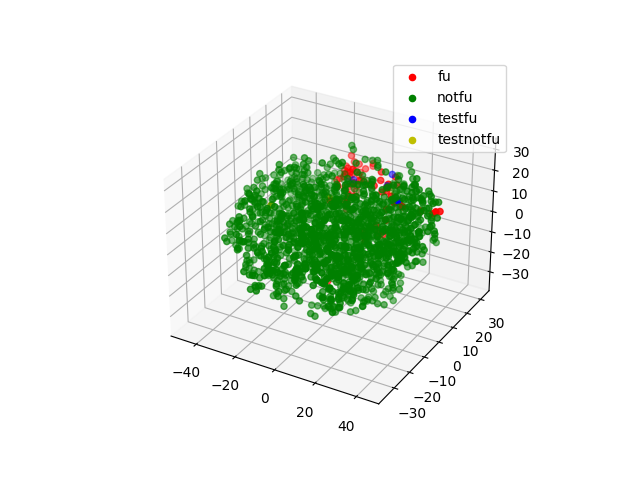

In [192]:
plotscatter(X)

In [200]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
X=pca.fit_transform(data)

In [177]:
X=np.concatenate((X,char_feat_norm,BOWfeat),axis=1)
X.shape

NameError: name 'char_feat_norm' is not defined

In [8]:
X=char_feat
X.shape

(1570, 80)

In [129]:
X=data
X.shape

(1570, 31)

In [167]:
X.shape

(1570, 1)

In [210]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X[:-10,:], y[:-10], test_size=0.2, random_state=42
)
X_test=X[-10:,:]
y_test=y[-10:]

In [211]:
from sklearn import svm

clf = svm.SVC(kernel='poly')
clf.fit(X[:-10,:], y[:-10])
y_pred = clf.predict(X_test)
y_pred

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [212]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(
    StandardScaler(),AdaBoostClassifier(n_estimators=800, random_state=0)
)
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('adaboostclassifier',
                 AdaBoostClassifier(n_estimators=800, random_state=0))])

In [218]:

from sklearn.metrics import f1_score
from hyperopt import hp
import xgboost as xgb

def train(args):
    learning_rate=args["learning_rate"]
    n_estimators=args["n_estimators"]
    eta=args["eta"]
    max_depth=args["max_depth"]
    subsample=args["subsample"]
    colsample_bytree=args["colsample_bytree"]
    min_child_weight=args["min_child_weight"]
    reg_alpha=args["reg_alpha"]
    reg_lambda=args["reg_lambda"]

    model = xgb.XGBClassifier(learning_rate=learning_rate,n_estimators=n_estimators,eta=eta,
                              max_depth=max_depth,subsample=subsample,colsample_bytree=colsample_bytree,
                              min_child_weight=min_child_weight,reg_alpha=reg_alpha,reg_lambda=reg_lambda)
    model.fit(X_train, y_train)
    return model

def objective(args):
    model=train(args)
    y_pred=model.predict(X_val)
    f1=f1_score(y_val,y_pred,average="macro")
    return -f1

space={"learning_rate":hp.choice("learning_rate", [0.1]),
    "n_estimators":hp.choice("n_estimators",[50, 100, 150, 200, 300]), # 多少棵树
    "eta": hp.choice("eta",[0.05, 0.1, 0, 2, 0.3]),  # 学习率
    "max_depth": hp.choice("max_depth",range(2, 15, 1)),  # 树的最大深度
    "subsample": hp.uniform("subsample", 0.7, 0.9),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.98),  # 选择多少列构建一个树
    "min_child_weight": hp.choice("min_child_weight",range(1, 9, 1)),  # 叶子节点最小样本数目
    "reg_alpha": hp.choice("reg_alpha",[0, 0.01, 0.02, 0.05, 0.7, 0.1, 1]),
    "reg_lambda": hp.choice("reg_lambda",[0, 0.1, 0.5, 1])}

from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=1000)
print(best)
print(space_eval(space, best))
clf=train(space_eval(space, best))

100%|██████████| 1000/1000 [02:19<00:00,  7.16trial/s, best loss: -0.8266666666666667]
{'colsample_bytree': 0.5272564634168748, 'eta': 3, 'learning_rate': 0, 'max_depth': 12, 'min_child_weight': 4, 'n_estimators': 3, 'reg_alpha': 4, 'reg_lambda': 3, 'subsample': 0.7334171865674561}
{'colsample_bytree': 0.5272564634168748, 'eta': 2, 'learning_rate': 0.1, 'max_depth': 14, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.7, 'reg_lambda': 1, 'subsample': 0.7334171865674561}


In [215]:
from sklearn.ensemble import RandomForestClassifier

clf = make_pipeline(RandomForestClassifier())
clf.fit(X_train, y_train)

Pipeline(steps=[('randomforestclassifier', RandomForestClassifier())])

In [219]:
from sklearn.metrics import f1_score
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(f1_score(y_val, y_pred, average="macro"))
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_pred)

0.8266666666666667


array([[296,   0],
       [  8,   8]])

In [220]:
clf.fit(X[:-10,:], y[:-10])
y_pred = clf.predict(X_test)
print(y_pred)
print(f1_score(y_test,y_pred, average="macro"))
print(confusion_matrix(y_pred, y_test))

[0 1 0 0 1 0 0 0 0 0]
0.6703296703296704
[[5 3]
 [0 2]]


In [221]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest


def intersection(hist_1, hist_2):
    minima = np.minimum(hist_1, hist_2)
    a = np.sum(minima)
    return a


def kernal(X1, X2):
    result = np.zeros((len(X1), len(X2)))
    for i in range(len(X1)):
        for j in range(len(X2)):
            result[i][j] = intersection(X1[i, :], X2[j, :])
    return result


from sklearn.svm import OneClassSVM
f1=[]
for nu in np.linspace(0.01,0.99,30):
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid',kernal]:
        clf = make_pipeline(OneClassSVM(nu=nu,kernel=kernel))
        clf .fit(X[:num_fu,:])

        y_pred = clf.predict(X[:-10,:])
        y_val_new=y[:-10]
        y_val_new[y_val_new==0]=-1
        f1s=f1_score(y_val_new, y_pred, average="macro")
        f1.append(f1s)

        from sklearn.metrics import f1_score

        y_pred = clf.predict(X[-10:,:])

        f12=f1_score(np.concatenate((np.ones(5), -np.ones(5))), y_pred, average="macro")
        print(f"f1:{f1s}, nu:{nu}, kernel:{kernel}, {f12}")

        # print(y_pred)
        # print(f1_score(np.concatenate((np.ones(5), -np.ones(5))), y_pred, average="macro"))
        # f1.append(f1_score(np.concatenate((np.ones(5), -np.ones(5))), y_pred, average="macro"))
        if f1_score(np.concatenate((np.ones(5), -np.ones(5))), y_pred, average="macro")==1.0:
            print(f"nu:{nu}, kernel:{kernel}")
        from sklearn.metrics import confusion_matrix

        confusion_matrix(np.concatenate((np.ones(5), -np.ones(5))), y_pred)
print(max(f1))
print(f1)

f1:0.5279756553011965, nu:0.01, kernel:linear, 0.3333333333333333
f1:0.588619905440182, nu:0.01, kernel:poly, 0.8000000000000002
f1:0.8003418803418803, nu:0.01, kernel:rbf, 0.6969696969696968
f1:0.5447760356457424, nu:0.01, kernel:sigmoid, 0.7916666666666665
f1:0.5926282668721505, nu:0.01, kernel:<function kernal at 0x7f86e52f4b80>, 0.898989898989899
f1:0.6734153621739893, nu:0.04379310344827586, kernel:linear, 0.5238095238095238
f1:0.5882555475085186, nu:0.04379310344827586, kernel:poly, 0.8000000000000002
f1:0.8040146291074569, nu:0.04379310344827586, kernel:rbf, 0.6969696969696968
f1:0.5517189593826533, nu:0.04379310344827586, kernel:sigmoid, 0.7916666666666665
f1:0.5903526845230881, nu:0.04379310344827586, kernel:<function kernal at 0x7f86e52f4b80>, 0.898989898989899
f1:0.637317394680294, nu:0.07758620689655171, kernel:linear, 1.0
nu:0.07758620689655171, kernel:linear
f1:0.5948863456690039, nu:0.07758620689655171, kernel:poly, 0.898989898989899
f1:0.8003418803418803, nu:0.077586206